# Notebook to accompany "A guide to LIGO-Virgo detector noise"

This notebook is intended to reproduce some plots from the paper "A guide to LIGO-Virgo detector noise and extratraction of transient gravitational-wave signals" (arXiv:1908.11170). This version is a slight modification on https://github.com/losc-tutorial/Data_Guide

The notebook was tested using python 3.7. 

This notebook is intended as an educational demonstration to reproduce some of the figures in the paper ["A guide to LIGO-Virgo detector noise and extraction of transient gravitational-wave signals"](https://inspirehep.net/record/1751757) , 
and may differ from the [C library code](https://doi.org/10.5281/zenodo.3380539) that has been used to produce the figures of the paper. Additional open source software libraries used by the LIGO Scientific Collaboration and Virgo Collaboration to produce published results are also available. See, for example, the list of open source libraries at https://www.gw-openscience.org/software/

## Import needed python modules

Most of these are common python packages, and can be easily installed using pip.  

In [1]:
# Standard python numerical analysis imports:
import numpy as np
import scipy
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt
import h5py
import json

# plotting items
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# -- Set some parameters that control how plots are displayed
plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['lines.linewidth'] = .75

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
! pip install -q gwpy

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
# LIGO-specific import
from gwpy.timeseries import TimeSeries

## Get the data

In [4]:
time_center = 1126259462

In [5]:
strain_H1 = TimeSeries.fetch_open_data('H1', time_center - 512, time_center + 512)

In [6]:
# both H1 and L1 will have the same time vector, so:
time = np.array(strain_H1.times)
fs = int(strain_H1.sample_rate.value)
dt = strain_H1.dt.value
strain_H1 = np.array(strain_H1)

## Calculate the noise power spectral density (PSD)

**NOTE**: to demonstrate the details of all operations, this notebook indexes directly a `gwpy.timeseries.TimeSeries`, treating them as numpy arrays. In practice one would instead us the `.crop()` method and the built-in bandpassing and whitening methods.

In [7]:
# number of sample for the fast fourier transform:
NFFT = 4 * fs           # Use 4 seconds of data for each fourier transform
NOVL = 1 * NFFT / 2     # The number of points of overlap between segments used in Welch averaging
psd_window = scipy.signal.tukey(NFFT, alpha=1./4)

Pxx_H1, freqs = mlab.psd(strain_H1, Fs=fs, NFFT=NFFT,
                         window=psd_window, noverlap=NOVL)

# smaller window if we're not doing Welch's method
short_indxt_away = np.where((time >= time_center - 2) & (
    time < time_center + 2))
# psd using a tukey window but no welch averaging
tukey_Pxx_H1, tukey_freqs = mlab.psd(
    strain_H1[short_indxt_away], Fs=fs, NFFT=NFFT, window=psd_window)
# psd with no window, no averaging
nowin_Pxx_H1, nowin_freqs = mlab.psd(
    strain_H1[short_indxt_away], Fs=fs, NFFT=NFFT, 
    window=mlab.window_none)

# We will use interpolations of the PSDs computed above for whitening:
psd_H1 = interp1d(freqs, Pxx_H1)

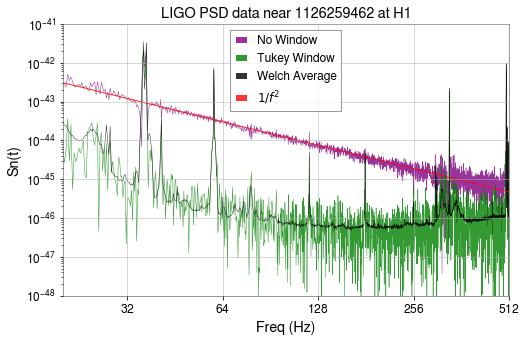

In [8]:
plt.figure(figsize=(8, 5))
# scale x and y axes
plt.xscale('log', basex=2)
plt.yscale('log', basey=10)

# plot nowindow, tukey, welch together 
plt.plot(nowin_freqs, nowin_Pxx_H1,'purple',label= 'No Window',
         alpha=.8, linewidth=.5)
plt.plot(tukey_freqs, tukey_Pxx_H1 ,'green',label='Tukey Window',
         alpha=.8, linewidth=.5)
plt.plot(freqs, Pxx_H1,'black',label='Welch Average', alpha=.8,
         linewidth=.5)

# plot 1/f^2
# give it the right starting scale to fit with the rest of the plots
# don't include zero frequency
inverse_square = np.array(list(map(lambda f: 1 / (f**2), 
                        nowin_freqs[1:])))
# inverse starts at 1 to take out 1/0
scale_index = 500 # chosen by eye to fit the plot
scale = nowin_Pxx_H1[scale_index]  / inverse_square[scale_index]
plt.plot(nowin_freqs[1:], inverse_square * scale,'red',
         label= r'$1 / f^2$', alpha=.8, linewidth=1)

plt.axis([20, 512, 1e-48, 1e-41])
plt.ylabel('Sn(t)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='upper center')
plt.title('LIGO PSD data near ' + str(time_center) + ' at H1')
plt.show()

Note that inadequate windowing of these strongly colored data produces a psd that 
is entirely dominated by "spectral leakage",
https://en.wikipedia.org/wiki/Spectral_leakage,
and inadequate averaging leads to noise fluctuations that contaminate the estimated PSD.


## Whiten and Bandpass Functions

Now we'll create some helper functions to whiten and bandpass data within a
given frequency band. These allow us to better see some signal in our data:

In [9]:
def whiten(strain, interp_psd, dt, phase_shift=0, time_shift=0):
    """Whitens strain data given the psd and sample rate, also applying a phase
    shift and time shift.

    Args:
        strain (ndarray): strain data
        interp_psd (interpolating function): function to take in freqs and output 
            the average power at that freq 
        dt (float): sample time interval of data
        phase_shift (float, optional): phase shift to apply to whitened data
        time_shift (float, optional): time shift to apply to whitened data (s)
    
    Returns:
        ndarray: array of whitened strain data
    """
    Nt = len(strain)
    # take the fourier transform of the data
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by square root of psd, then
    # transform back, taking care to get normalization right.
    hf = np.fft.rfft(strain)
    
    # apply time and phase shift
    hf = hf * np.exp(-1.j * 2 * np.pi * time_shift * freqs - 1.j * phase_shift)
    norm = 1./np.sqrt(1./(dt*2))
    white_hf = hf / np.sqrt(interp_psd(freqs)) * norm
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

def bandpass(strain, fband, fs):
    """Bandpasses strain data using a butterworth filter.
    
    Args:
        strain (ndarray): strain data to bandpass
        fband (ndarray): low and high-pass filter values to use
        fs (float): sample rate of data
    
    Returns:
        ndarray: array of bandpassed strain data
    """
    bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
    normalization = np.sqrt((fband[1]-fband[0])/(fs/2))
    strain_bp = filtfilt(bb, ab, strain) / normalization
    return strain_bp

## Plot strain data that has been windowed, bandpassed, and whitened

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


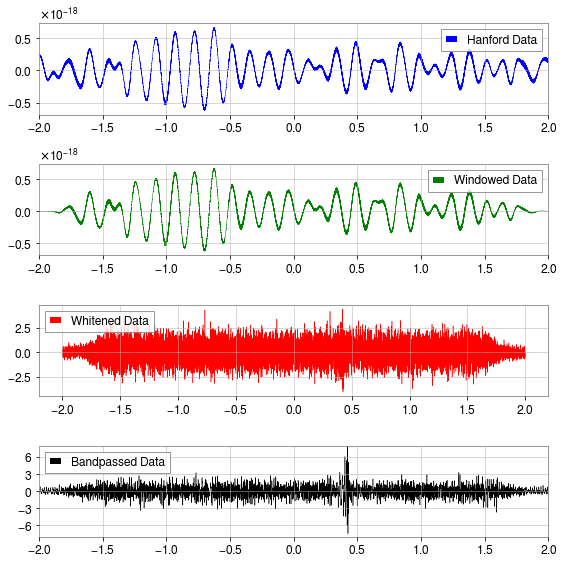

In [10]:
fband = [35.0, 350.0]

# create our 4 second data window
window_len = 4*fs
dwindow = scipy.signal.tukey(window_len, alpha=1./4)

# plot original strain data
# only care about 4s around event
plt.figure(figsize=(8, 8))
plt.subplot(4, 1, 1)
indxt = np.where((time >= time_center - 2) & (time < time_center + 2))
plt.xlim([-2, 2])
plt.plot(time[indxt] - time_center, strain_H1[indxt], 'blue', 
         label='Hanford Data', linewidth=.5)
plt.legend()

# plot windowed data
plt.subplot(4, 1, 2)
strain_windowed = dwindow * strain_H1[indxt]
plt.xlim([-2, 2])
plt.plot(time[indxt] - time_center, strain_windowed, 'green', 
         label='Windowed Data', linewidth=.5)
plt.legend()

# plot whitened data
plt.subplot(4, 1, 3)
strain_whitened = whiten(strain_windowed, psd_H1, dt)
plt.plot(time[indxt] - time_center, strain_whitened, 'red', 
         label='Whitened Data', linewidth=.5)
plt.legend()

# plot bandpassed data
plt.subplot(4, 1, 4)
strain_bp = bandpass(strain_whitened, fband, fs)
plt.xlim([-2, 2])
plt.plot(time[indxt] - time_center, strain_bp, 'black', 
         label='Bandpassed Data', linewidth=.5)

plt.legend()
plt.yticks([-6, -3, 0, 3, 6, 9])
plt.tight_layout()
plt.xlim([-2, 2])
plt.ylim([-8, 8])
plt.show()

## Fourier phases

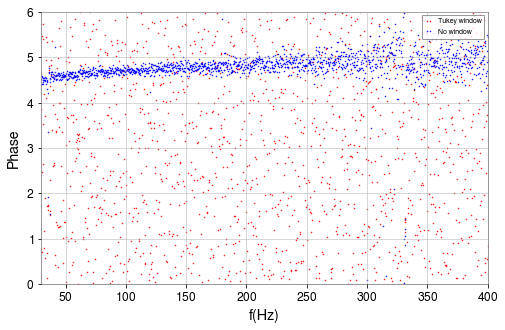

In [11]:
data2=strain_H1[indxt]

# Plots Fourier phases of strain data both with and without a spectral window
plt.figure(figsize=(8, 5))
tukey_window = signal.tukey(data2.size, alpha=1./4),
labels = ['Tukey window', 'No window']
colors = ['red', 'blue']

# apply each window and find phases of the fft
for i, dwindow in enumerate([tukey_window, 1]):
    data_fft = np.fft.rfft((data2 * dwindow).flatten()) * dt
    datafreq = np.fft.rfftfreq(data2.size) / dt
    phases = np.angle(data_fft)
    # convert angles to range (0, 2 pi)
    phases = (phases + 2 * np.pi) % (2 * np.pi)
    plt.plot(datafreq, phases, '.', label=labels[i], 
             color=colors[i], markersize=1)

plt.xlim([30, 400])
plt.ylim([0, 6])
plt.xlabel('f(Hz)')
plt.ylabel('Phase')
plt.legend(loc='upper right', fontsize=7)

Note that the fourier phases for properly windowed data (random noise) are random between [0, 2*pi];
by contrast, un-windowed data produce strongly correlated fourier phases that are artifacts of the abrupt beginning and end of the data stretch.

## Define matched filter method to search for a waveform in data

In [12]:
def matched_filter(template, data, time, data_psd, fs):
    """Runs the matched filter calculation given a specific real template, strain
    data, time, psd, and sample rate. Finds the offset and phase to maximize
    SNR, as well as effective distance and horizon

    Args:
        template (ndarray): real part of initial template corresponding to event
        data (ndarray): strain data near event
        time (ndarray): time near event
        data_psd (interpolating function): psd of strain data around event
        fs (float): sample rate of data
    
    Returns:
        float: maximum SNR value obtained
        float: time of maximum SNR value
        float: effective distance found
        float: horizon found
        float: template phase which maximizes SNR
        float: template offset which maximizes SNR
    """

    # get the fourier frequencies of data for when we fft (for dividing by psd)
    datafreq = np.fft.fftfreq(template.size)*fs
    df = np.abs(datafreq[1] - datafreq[0])
    # for taking the fft of our template and data
    dwindow = signal.tukey(template.size, alpha=1./4)
    # compute the template and data ffts.
    template_fft = np.fft.fft(template*dwindow) / fs
    data_fft = np.fft.fft(data*dwindow) / fs

    # use the larger psd of the data calculated earlier for a better calculation
    power_vec = list(map(data_psd, np.abs(datafreq)))

    # -- Zero out negative frequencies
    negindx = np.where(datafreq<0)
    data_fft[negindx] = 0

    # -- Calculate the matched filter output in the time domain: Multiply
    # the Fourier Space template and data, and divide by the noise power in
    # each frequency bin.  Taking the Inverse Fourier Transform (IFFT) of
    # the filter output puts it back in the time domain, so the result will
    # be plotted as a function of time off-set between the template and the
    # data:
    optimal = data_fft * template_fft.conjugate() / power_vec  
    optimal_time = 4 * np.fft.ifft(optimal) * fs

    # -- Normalize the matched filter output: Normalize the matched filter
    # output so that we expect an average value of 1 at times of just noise.  Then,
    # the peak of the matched filter output will tell us the
    # signal-to-noise ratio (SNR) of the signal.
    sigmasq = 2 * (template_fft * template_fft.conjugate() / power_vec).sum() * df
    sigma = np.sqrt(np.abs(sigmasq))
    SNR_complex = optimal_time/sigma

    # shift the SNR vector by the template length so that the peak is at
    # the end of the template
    peaksample = int(data.size / 2)  # location of peak in the template
    SNR_complex = np.roll(SNR_complex,peaksample)
    SNR = abs(SNR_complex)

    # find the time and SNR value at maximum:
    indmax = np.argmax(SNR)
    timemax = time[indmax]
    SNRmax = SNR[indmax]

    # Calculate the effective distance
    d_eff = sigma / SNRmax
    # -- Calculate optimal horizon distnace
    horizon = sigma/8

    # Extract time offset and phase at peak
    phase = -np.angle(SNR_complex[indmax])
    offset = (indmax-peaksample)

    return SNRmax, timemax, d_eff, horizon, phase, offset

## Define helper function to apply time and phase shifts

In [13]:
def get_shifted_data(template_p, strain, time, strain_whiten,
                     strain_whitenbp, fband, filter_data, data_psd):
    """Obtains data shifts of templates and residual data after having found the
    best fit phase and offsets for the template.
    
    Args:
        template_p (ndarray): real (plus-polarization) part of template
        strain (ndarray): strain data
        time (ndarray): time
        strain_whiten (ndarray): whitened strain data
        strain_whitenbp (ndarray): whitened and bandpassed strain data
        fband (list): low and high pass filters for the template bandpass 
        filter_data (dict): dictionary containing phase, offset, d_eff values 
            for given matched filter calculation
        data_psd (interpolating function): function which outputs a power value
            for a given data frequency 

    Returns:
        ndarray: whitened, bandpassed, phaseshifted and offset template
        ndarray: phaseshifted and offset residual data
        ndarray: whitened, phaseshifted and offset residual data
        ndarray: whitened, bandpassed, phaseshifted and offset residual data
    """
    d_eff = filter_data['d_eff']
    phase = filter_data['phase']
    offset = filter_data['offset']

    # apply time and phase shift to template- we'll do this in the freq domain
    Nt = len(template_p)
    freqs = np.fft.rfftfreq(Nt, dt)
    # apply the fft, also scaling initial amplitude
    hf = np.fft.rfft(template_p / d_eff)
    # apply phase shift, time offset
    hf = hf * np.exp(-1.j * 2 * np.pi * (offset * dt) * freqs - 1.j * phase)
    # transform back
    template_shifted = np.real(np.fft.irfft(hf, n=Nt))

    # whiten and bandpass template_p for plotting- also applying phase shift,
    # amplitude scale
    template_whitened = whiten(template_p / d_eff, data_psd, dt,
                               phase_shift=phase, time_shift=(offset * dt))
    template_match = bandpass(template_whitened, fband, 1. / dt)

    # save the residual for later
    resid_data_whiten= strain_whiten - template_whitened
    resid_data_whitenbp = strain_whitenbp - template_match

    # save the nonbandpassed, nonwhitened residual as well
    resid_data = strain - template_shifted
    return template_match, resid_data, resid_data_whiten, resid_data_whitenbp

## Read in, taper, and zero-pad the waveform template

In [14]:
# -- Download waveform template
! wget -q -N https://www.gw-openscience.org/GW150914data/P150914/fig2-unfiltered-waveform-H.txt

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/scipy/signal/signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/scipy/signal/signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/scipy/signal/signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will b

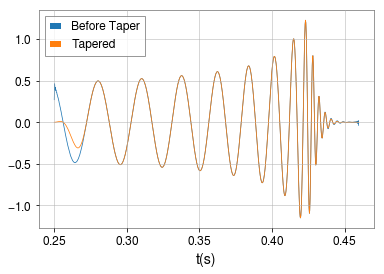

In [15]:
fig_template = np.genfromtxt('fig2-unfiltered-waveform-H.txt')

# Remove the time vector
fig_template = fig_template[:, 1]

# Downsample this data to 4096 Hz
fig_template = scipy.signal.resample(fig_template, int(len(fig_template)/4) )

# apply a Tukey window to taper the ends of the template
taper_window = signal.tukey(len(fig_template), alpha=.25)
fig_template_tapered = fig_template * taper_window

# -- Plot template before and after tapering
template_time = np.arange(0.25, 0.25+len(fig_template_tapered)*dt,dt)
plt.plot(template_time, fig_template, label='Before Taper')
plt.plot(template_time, fig_template_tapered, label='Tapered')
plt.xlabel('t(s)')
plt.legend()

# Now we need to pad this with 0s to make it the same amount of time as the data
halfdatalen = int(16*fs)
begin_add = halfdatalen - len(fig_template_tapered)

# add last 2048 seconds
fig_template_tapered = np.append(fig_template_tapered, (halfdatalen * [0]))
# add beginning- almost 2048 seconds
fig_template_tapered = np.append((int(begin_add) * [0]), fig_template_tapered)


The effect of the tapering Tukey window is visible at the beginning of the template.  Tapering forces the template to have zero values at the ends, in order to avoid artefacts due to discontinuities when taking an FFT.

## Use the methods defined above to calculate the matched filter result for GW150914

Note, the results of matched filtering are sensitive to small changes in PSD estimation, and so running similar codes may not give identical results.   The calculated SNR is particularly sensitive, and differences of a few percent between different implementations are typically expected.

In [16]:
template_p = fig_template_tapered

# these specific values are defined in the paper
fband = [35.0, 350.0]

# Getting a more manageable 32s. of data:
strain_H1 = TimeSeries.fetch_open_data('H1', time_center - 16, time_center + 16)
time = np.array(strain_H1.times)
strain_H1 = np.array(strain_H1)


In [17]:
strain_whitened = whiten(strain_H1, psd_H1, dt)
strain_bp = bandpass(strain_whitened, fband, fs)

t_amount = 4

filter_data = {'H1': {}, 'L1': {}}

# amount of data we want to calculate matched filter SNR over- up to 32s
data_time_window = time[len(time) - 1] - time[0] - (32 - t_amount)

time_filter_window = np.where((time <= time_center + data_time_window * .5) &
                              (time >= time_center - data_time_window * .5))
time_filtered = time[time_filter_window]
template_p = template_p[time_filter_window]
strain_whitened = strain_whitened[time_filter_window]
strain_bp = strain_bp[time_filter_window]
strain_H1_4 = strain_H1[time_filter_window]

# define the template using only the plus polarization
template = template_p

# save the time for later
filter_data['time'] = time_filtered

# find the best fit phase, offset, d_eff, horizon
SNRmax, timemax, d_eff, horizon, phase, offset = matched_filter(
    template, strain_H1_4, time_filtered, psd_H1, fs)

# save these vals for later
filter_data['SNR'] = SNRmax
filter_data['d_eff'] = d_eff
filter_data['phase'] = phase
filter_data['offset'] = offset

print("The phase offset is {0:.3f} radians".format(phase))
print('Maximum at {0:.4f} with SNR = {1:.1f}, ' 
      .format(timemax, SNRmax))

# get residuals and whitened data/template
template_wbp, resid_data, resid_data_w, resid_data_wbp = get_shifted_data(
    template_p, strain_H1_4, time_filtered, strain_whitened,
    strain_bp, fband, filter_data, psd_H1)

filter_data['residual'] = resid_data
filter_data['residual_whiten'] = resid_data_w
filter_data['residual_whitenbp'] = resid_data_wbp

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


The phase offset is -0.285 radians
Maximum at 1126259462.4602 with SNR = 19.0, 


Text(0.5,0,'Time since 1126259462.0000')

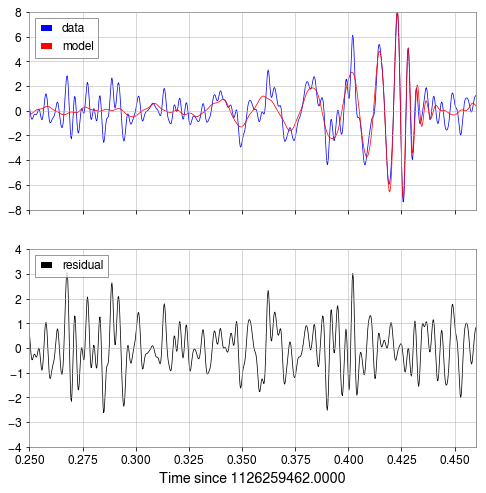

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# plot whitened, phase and time shifted templates, data, residuals
ax = axes[0]
ax.plot(time_filtered - time_center, strain_bp, 'b',
        label='data')
ax.plot(time_filtered - time_center, template_wbp, 'r',
        label='model')
ax.set_ylim([-8, 8])
ax.legend(loc='upper left')

ax = axes[1]
ax.plot(time_filtered - time_center, resid_data_wbp, 'k', 
        label='residual')
ax.set_ylim([-4, 4])
ax.legend(loc='upper left')
plt.xlim([.25, .46])
plt.xlabel('Time since {0:.4f}'.format(time_center))

# Exercises

* Do the calculations for L1
* Calculate the cross correlation between the H1 and L1 data
* Calculate the cross correlation between the H1 and L1 residual